In [9]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

## 1. Data collection 

In [10]:
nasdaq = pd.read_excel("NASDAQ.xlsx")
tickers = nasdaq['Symbol']
tickers_list = list()
for ticker in tickers:
    tickers_list.append(ticker)

In [11]:
#data = yf.download(tickers_list,'2019-01-02','2019-12-31')
#data.to_pickle('ticker_data')

In [12]:
#stock data
data = pd.read_pickle('ticker_data')
data = data.drop(columns = ['Low', 'High', 'Open', 'Close'])
#market index data
index = pd.read_csv('index_ixic.csv', sep=",")
index = index.drop(columns = ['Low', 'High', 'Open', 'Close'])

In [13]:
adj_close = data['Adj Close'] # adjusted closing price
volume = data['Volume'] # sales volume


adj_close.reset_index(level=0, inplace=True) # set index from date to int
volume.reset_index(level=0, inplace=True)

for i in range(0, len(adj_close['Date'])):
    volume.loc[i, 'Date'] = str(volume['Date'][i].date())
    adj_close.loc[i, 'Date'] = str(adj_close['Date'][i].date())


adj_indexes = set(adj_close['Date'].to_list())
ind_indexes = set(index['Date'].to_list())
diff = adj_indexes.difference(ind_indexes)
diff, adj_close.shape, index.shape

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


({'2019-11-28'}, (252, 5014), (251, 3))

In [14]:
adj_close = adj_close.loc[adj_close['Date'] != '2019-11-28']
volume = volume.loc[volume['Date'] != '2019-11-28']

#handling missing values
adj_close = adj_close.dropna(axis=1, how='any')
volume = volume.dropna(axis=1, how='any')

#add the index data to the main data
adj_close['IXIC'] = index['Adj Close']
volume['IXIC'] = index['Volume']

#delete last day as ixic is nan
adj_close = adj_close.loc[adj_close['Date'] != '2019-12-30']
volume = volume.loc[volume['Date'] != '2019-12-30']

#reindex after drop
adj_close.reset_index(drop=True, inplace=True)

In [15]:
#reduce the number of tickers
tickers_to_delete = adj_close.columns.to_list()
tickers_to_delete.remove('Date')
tickers_to_delete.remove('IXIC')
tickers_to_delete = tickers_to_delete[::2]
adj_close.drop(tickers_to_delete, inplace=True, axis=1) 
volume.drop(tickers_to_delete, inplace=True, axis=1) 

## 2. Logarithmic returns, expected value and standard deviation estimations


In [16]:
# calculate logarithmic returns
log_returns = pd.DataFrame(index = adj_close.index, columns = adj_close.columns)
log_returns['Date'] = adj_close['Date']
tickers = adj_close.columns.to_list()
tickers.remove('Date')


num_days=len(log_returns['AADR'])
for ticker in tickers:
    for i in range(1, num_days):
        log_returns.loc[i, ticker] = np.log(adj_close.loc[i, ticker]/adj_close.loc[i-1, ticker])
#droping first day
log_returns = log_returns.dropna(axis=0, how='any')
log_returns.reset_index( drop=True, inplace=True) 


In [17]:
log_returns

,Date,AADR,AAOI,AAPL,AAXJ,ABEO,ABMD,ABUS,ACB,ACER,...,ZEAL,ZEUS,ZGNX,ZIONO,ZIXI,ZLAB,ZS,ZUMZ,ZYXI,IXIC
0,2019-01-03,-0.011221,-0.053018,-0.104924,-0.0239,-0.060091,-0.025056,-0.059219,-0.019268,-0.05019,...,0.025581,0.005219,0.0,0.001177,0.008525,-0.026814,-0.012385,-0.01334,-0.02452,-0.03084
1,2019-01-04,0.03813,0.031375,0.041803,0.032423,0.058668,0.036221,0.083912,0.015444,0.052518,...,0.04098,0.067908,0.075212,0.012858,0.011815,0.01327,0.060445,0.024995,0.045068,0.04172
2,2019-01-07,0.011758,0.008969,-0.002228,0.005954,0.067472,0.00433,0.024098,0.007634,0.071347,...,0.045176,0.036411,0.049797,0.004635,0.010017,0.026907,0.041961,0.046268,0.003384,0.012477
3,2019-01-08,0.006894,0.020828,0.018884,0.002652,-0.026992,0.011434,-0.036368,-0.044711,0.017601,...,0.005776,0.008754,0.026254,0.013017,0.051792,0.005736,0.009596,0.014327,-0.00678,0.010718
4,2019-01-09,0.016681,0.006847,0.016839,0.016994,0.0,0.05493,-0.058467,0.080196,0.004246,...,0.019464,0.019563,-0.001804,-0.004193,-0.02233,0.019604,0.020257,0.008499,0.020203,0.008673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2019-12-20,0.008244,-0.016057,-0.002073,0.003156,-0.471605,-0.039365,0.237081,-0.00885,-0.033379,...,0.033544,-0.019242,-0.011079,-0.006804,0.010409,-0.014257,0.025146,-0.014335,-0.048603,0.002316
245,2019-12-23,0.002423,0.002694,0.016187,0.000411,0.1514,0.045308,-0.049656,-0.112795,0.015544,...,-0.006127,0.023158,0.024477,0.003945,0.056089,0.005115,-0.019733,0.014644,0.044851,0.000808
246,2019-12-24,0.005199,-0.002694,0.00095,-0.003017,-0.008299,0.010854,0.0,-0.01,0.020357,...,0.008111,0.002231,-0.005262,-0.001433,-0.019775,-0.008454,-0.008967,-0.001858,0.021079,0.007734
247,2019-12-26,0.00554,0.043121,0.019646,0.006161,0.0,-0.007515,-0.048427,0.005013,-0.012674,...,0.03578,0.005556,-0.009086,-0.009363,-0.028946,-0.016602,0.008759,0.026603,-0.013589,-0.001749


In [18]:
#calculate the estimates of the mathematical expectation and std for each stock
ListOfStats = ['Mean', 'Std']

stats = pd.DataFrame(columns = ListOfStats, index = tickers)

for ticker in tickers:
    mean = np.mean(log_returns[ticker]) # 
    std = np.std(log_returns[ticker], ddof = 1) # variance (дисперсия), должно быть стандартное отклонение 
    #std2 = np.std(log_returns[ticker])

    stats['Mean'][ticker] = mean
    stats['Std'][ticker] = std

stats

,Mean,Std
AADR,0.001235,0.008511
AAOI,-0.001289,0.036041
AAPL,0.002498,0.016661
AAXJ,0.000701,0.009774
ABEO,-0.002894,0.074371
...,...,...
ZLAB,0.002372,0.026232
ZS,0.000719,0.033408
ZUMZ,0.002048,0.028866
ZYXI,0.004114,0.045198


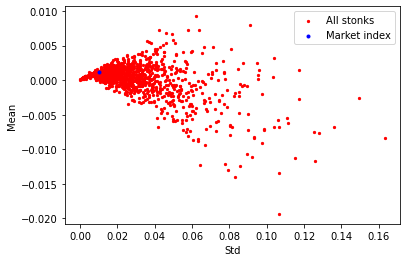

In [19]:
stats.plot(x='Std', y='Mean', color="red", kind="scatter", marker=".", label='All stonks') # лайк за стонкс) 
plt.scatter(stats['Std']['IXIC'], stats['Mean']['IXIC'], marker=".", color="blue", label='Market index')
plt.legend()
plt.show()

## 3-4. Equally weighted portfolio, stock market index  

In [25]:
log_returns_without_date = log_returns.drop(columns = ['Date'])

In [28]:
#equally weighted portfolio return
returns_balanced = []
for index, row in log_returns_without_date.iterrows():
    returns_balanced.append(np.sum(row)/len(tickers))

mean_balanced = np.round(np.mean(returns_balanced), 5)
std_balanced = np.round(np.std(returns_balanced), 5)

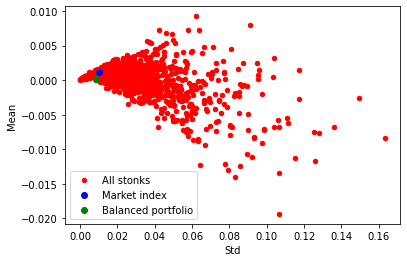

In [29]:
stats.plot(x='Std', y='Mean', color="red", kind="scatter", label='All stonks')
plt.scatter(stats['Std']['IXIC'], stats['Mean']['IXIC'], color="blue", label='Market index')
plt.scatter(std_balanced, mean_balanced, color="green", label='Balanced portfolio')
plt.legend()
plt.show()

# 5. VaR

In [ ]:
#VaR_gam = mu + sigma*U_gamma where U_gamma is Z-score? wtf

gamma1 = 0.95
gamma2 = 0.90

gamma_quantile1 = scipy.stats.norm.ppf(gamma1) # percentage point function
gamma_quantile2 = scipy.stats.norm.ppf(gamma2)

z_score1, z_score2

VaR1 = stats['Std']*gamma_quantile1 + stats['Mean']
VaR2 = stats['Std']*gamma_quantile2 + stats['Mean']

## 6. White noise

## 7. 

## 8. 